# List of plots

 1. [Bar chart of 'configure+build+test' times by site by extension](#plot_1)
 2. [Gantt chart of |configure, build, test| times by extension (ordered by start times)](#plot_2)


## Prerequisites

In [1]:
! pip install arrow

## Download data from CDash

Using `cdashapi.Downloader`, we can selectively download data.


In [2]:
url = "slicer.cdash.org"
project = "Slicer4"

sites = ['factory-south-ubuntu', 'factory-south-w', 'factory']
date = "2016-04-24"
group = "Extensions-Nightly"

from cdashapi import Downloader

sites_data = {}

for site in sites:
    print("Downloading '%s' site data..." % site)
    sites_data[site] = (
        Downloader(url, project, date=date).debug(False).
        site(site).
        groupname(group)()
    )
    
# pp(sites_data[site])

## Transform data


In [3]:
import arrow
import pandas as pd

from cdashapi import Transformer

# Create dataframe with 
#  
#  * a hierarchical index of the form: <sites> ( <names> )
#
#  * data columns

sites_data_columns = ['start_times']

timedelta_columns = ['configure_times', 'build_times', 'test_times']
sites_data_columns.extend(timedelta_columns)

error_columns = ['configure_errors', 'build_errors']
sites_data_columns.extend(error_columns)

data_columns = list(sites_data_columns)

sites_df = None

for site, submission_data in sites_data.items():
    
    site_data = (Transformer(submission_data).
                 labels().
                 start_times(update=lambda value:pd.Timestamp(arrow.get(value).datetime)).
                 configure_times().build_times().test_times().
                 configure_errors().build_errors().transformed_data())
    
    # Keys for each level of indexing
    sites_index = [site]
    names_index = site_data['labels']
    
    # Explicit building of the index and association of names with each levels
    index = pd.MultiIndex.from_product([sites_index, names_index],
                                       names=['sites', 'names'])
    
    # Convert column based representation into list of tuples
    data_tuples = list(zip(*(site_data[key] for key in sites_data_columns)))
    
    # Create site dataframe with (1) list of data tuples and (2) hierarchical index
    site_df = (pd.DataFrame(data_tuples, index=index, columns=sites_data_columns))
    
    # Compute errors <= configure_errors + build_errors
    site_df['errors'] = site_df[error_columns].sum(axis=1)
    if 'errors' not in data_columns: data_columns.append('errors')
    
    print(" site_df: [%d rows x %d columns][%s]" % (*site_df.shape, site))
    
    if sites_df is None:
        sites_df = site_df
    else:
        sites_df = sites_df.merge(site_df, left_index=True, right_index=True, how='outer', on=data_columns)

print("sites_df: [%d rows x %d columns]" % (sites_df.shape))

 site_df: [82 rows x 7 columns][factory-south-ubuntu]
 site_df: [86 rows x 7 columns][factory-south-w]
 site_df: [94 rows x 7 columns][factory]
sites_df: [262 rows x 7 columns]


## Display cumulative times for all extensions

In [4]:
import numpy as np

# Sum values associated for the current site and 'times' index keys
print("For all extensions on %s :" % date)
for site in sites:
    print("  site: %s" % site)
    cumulative_times = sites_df.xs((site), level=('sites'))[timedelta_columns].sum() / np.timedelta64(1, 'h')
    for key in timedelta_columns:
        print("    %s: %.2f hrs" % (key, cumulative_times[key]))
    total = (sites_df.xs((site), level=('sites'))[timedelta_columns]).sum(axis=1).sum() / np.timedelta64(1, 'h')
    print("    (configure + build + test) time: %.2f hrs" % (total))
    print("")

For all extensions on 2016-04-24 :
  site: factory-south-ubuntu
    configure_times: 0.12 hrs
    build_times: 6.14 hrs
    test_times: 0.25 hrs
    (configure + build + test) time: 6.51 hrs

  site: factory-south-w
    configure_times: 0.52 hrs
    build_times: 5.70 hrs
    test_times: 0.64 hrs
    (configure + build + test) time: 6.86 hrs

  site: factory
    configure_times: 0.17 hrs
    build_times: 4.10 hrs
    test_times: 0.77 hrs
    (configure + build + test) time: 5.04 hrs



In [5]:
import pandas as pd

def merge(_dfs, **kwargs):
    dfs = list(_dfs) # Copy
    #print(dfs)
    merged = None
    if len(dfs) > 0:
        merged = dfs.pop(0)
    while len(dfs) > 0:
        merged = pd.merge(merged, dfs.pop(0), **kwargs)
    return merged

from IPython.display import display, HTML 
def section(_id):
    #print("Adding <a id='%s'></a>" % _id)
    display(HTML("<a id='%s'></a>" % _id))

## Visualize extension times and errors

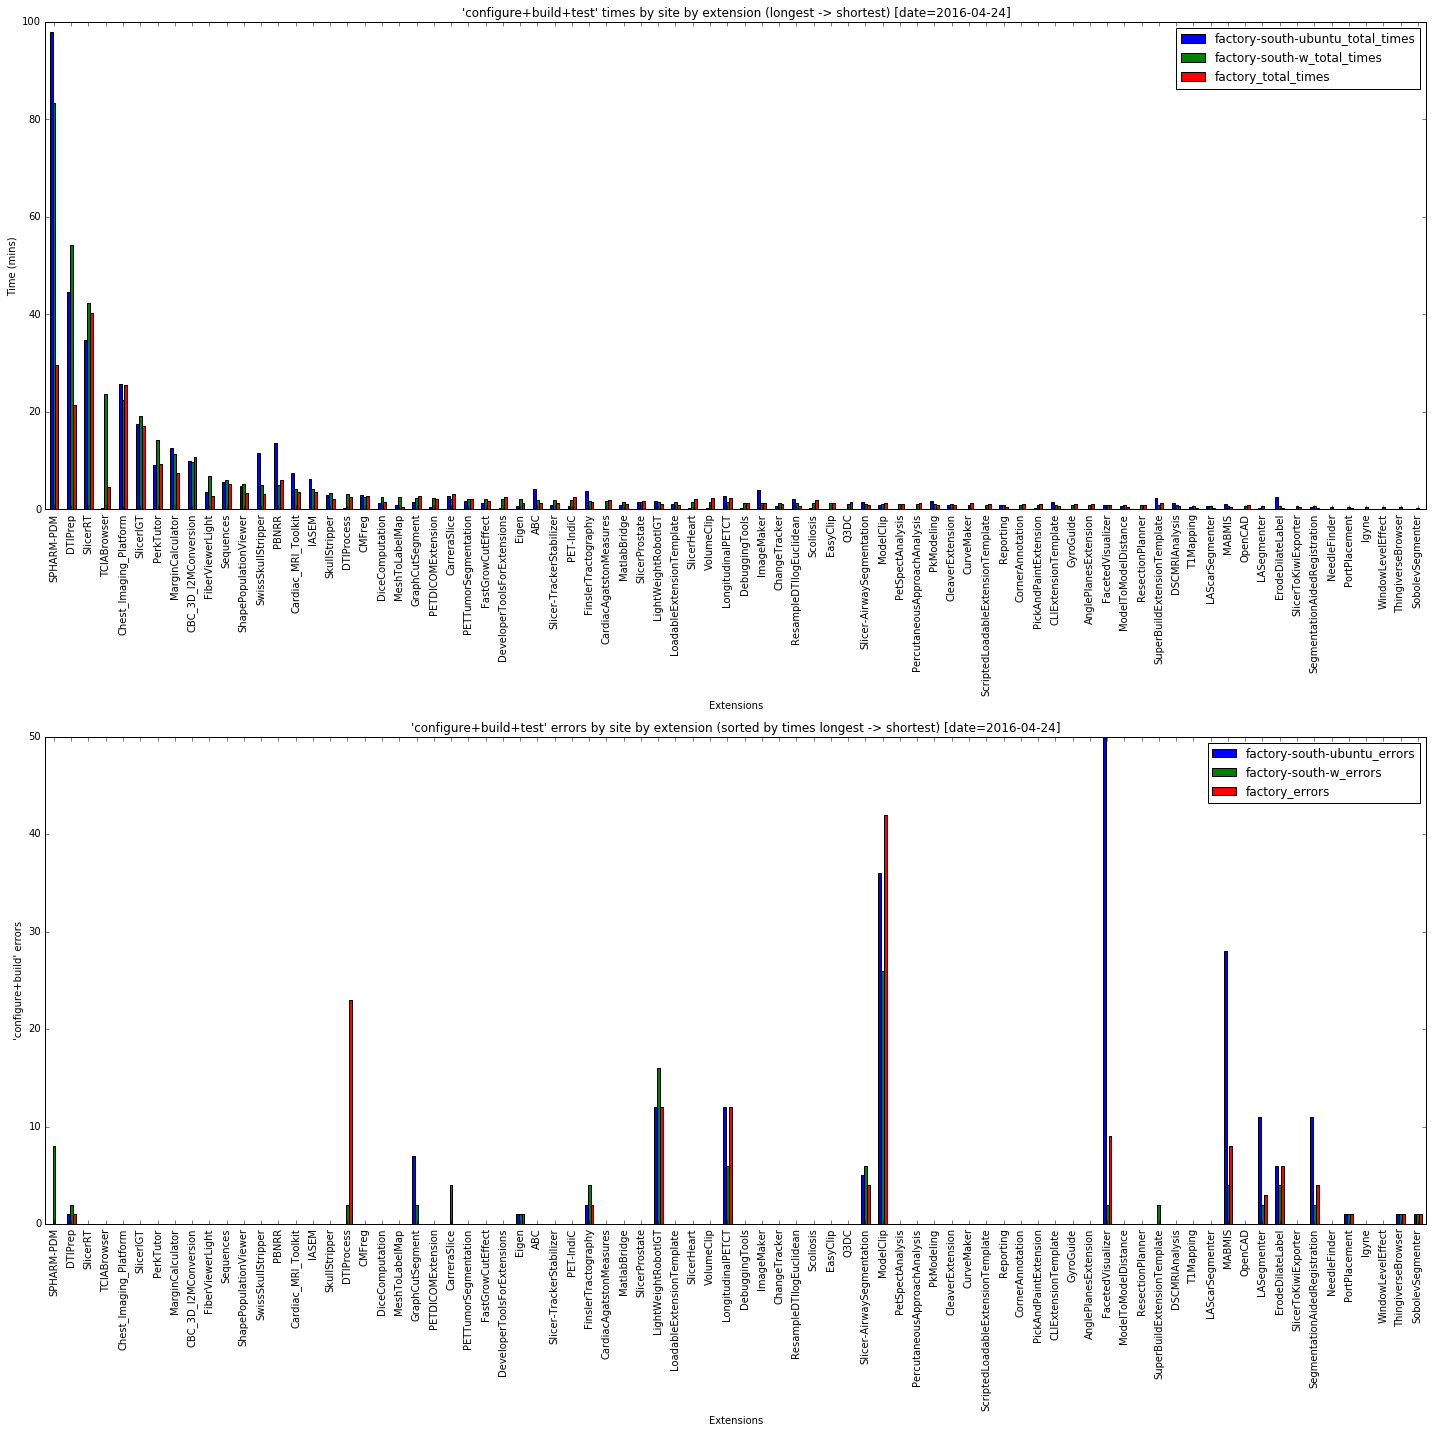

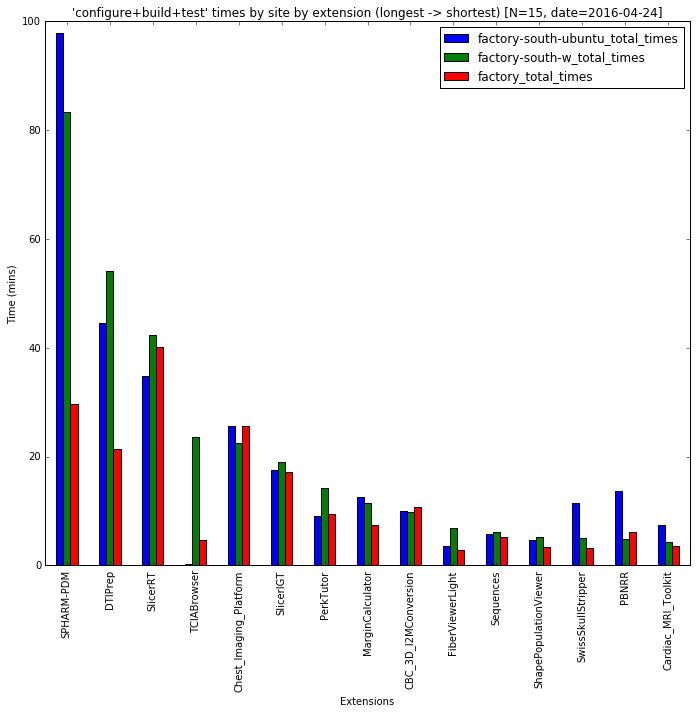

In [6]:
%matplotlib inline

section('plot_1')

import matplotlib.pyplot as plt

figsize = (20, 20)
sharex = False

# fig, axes = plt.subplots(2, sharex=sharex)
# axes_index = iter(range(len(axes)))

# subplot
title = "'configure+build+test' times by site by extension (alphabetical) [date=%s]" % date

time_plot_df = merge(
    [(sites_df.xs((site), level=('sites'))                       # for each site
      [timedelta_columns].sum(axis=1) / np.timedelta64(1, 'm')). # compute total_times <= configure+build+test
     to_frame('%s_total_times' % site)                           # convert from time series and rename
     for site in sites],
    left_index=True, right_index=True                            # finally, merge
).sortlevel(level='names')                                       # and sort

# ax = time_plot_df.plot.bar(ax=axes[next(axes_index)], figsize=figsize, title=title, use_index=True)
# ax.set_xlabel("Extensions")
# ax.set_ylabel("Time (mins)")

# subplot
title = "'configure+build' errors by site by extension (alphabetical) [date=%s]" % date

error_plot_df = merge(
    [(sites_df.xs((site), level=('sites'))                       # for each site
      ['errors']). # compute total_times <= configure+build+test
     to_frame('%s_errors' % site)                                # convert from time series and rename
     for site in sites],
    left_index=True, right_index=True                            # finally, merge
).sortlevel(level='names')                                       # and sort

# ax = error_plot_df.plot.bar(ax=axes[next(axes_index)], figsize=figsize, title=title, use_index=True)
# ax.set_xlabel("Extensions")
# ax.set_ylabel("'configure+build' errors")

#plt.tight_layout()

#-------------------------------------------------------------------------------

fig, axes = plt.subplots(2, sharex=sharex)
axes_index = iter(range(len(axes)))

# subplot
title = "'configure+build+test' times by site by extension (longest -> shortest) [date=%s]" % date

time_plot_df = time_plot_df.sort_values(by='factory-south-w_total_times', ascending=False)

ax = time_plot_df.plot.bar(ax=axes[next(axes_index)], figsize=figsize, title=title, use_index=True)
ax.set_xlabel("Extensions")
ax.set_ylabel("Time (mins)")

# subplot
title = "'configure+build+test' errors by site by extension (sorted by times longest -> shortest) [date=%s]" % date

error_plot_df = error_plot_df.reindex_axis(time_plot_df.index.get_level_values('names'))

ax = error_plot_df.plot.bar(ax=axes[next(axes_index)], figsize=figsize, title=title, use_index=True)
ax.set_xlabel("Extensions")
ax.set_ylabel("'configure+build' errors")

plt.tight_layout()

#-------------------------------------------------------------------------------

fig = plt.figure()
figsize = (10, 10)

number=15
title = "'configure+build+test' times by site by extension (longest -> shortest) [N=%d, date=%s]" % (number, date)

time_plot_df = time_plot_df.head(number)

ax = time_plot_df.plot.bar(figsize=figsize, title=title, use_index=True)
ax.set_xlabel("Extensions")
ax.set_ylabel("Time (mins)")

plt.tight_layout();

## Gantt chart of extension times

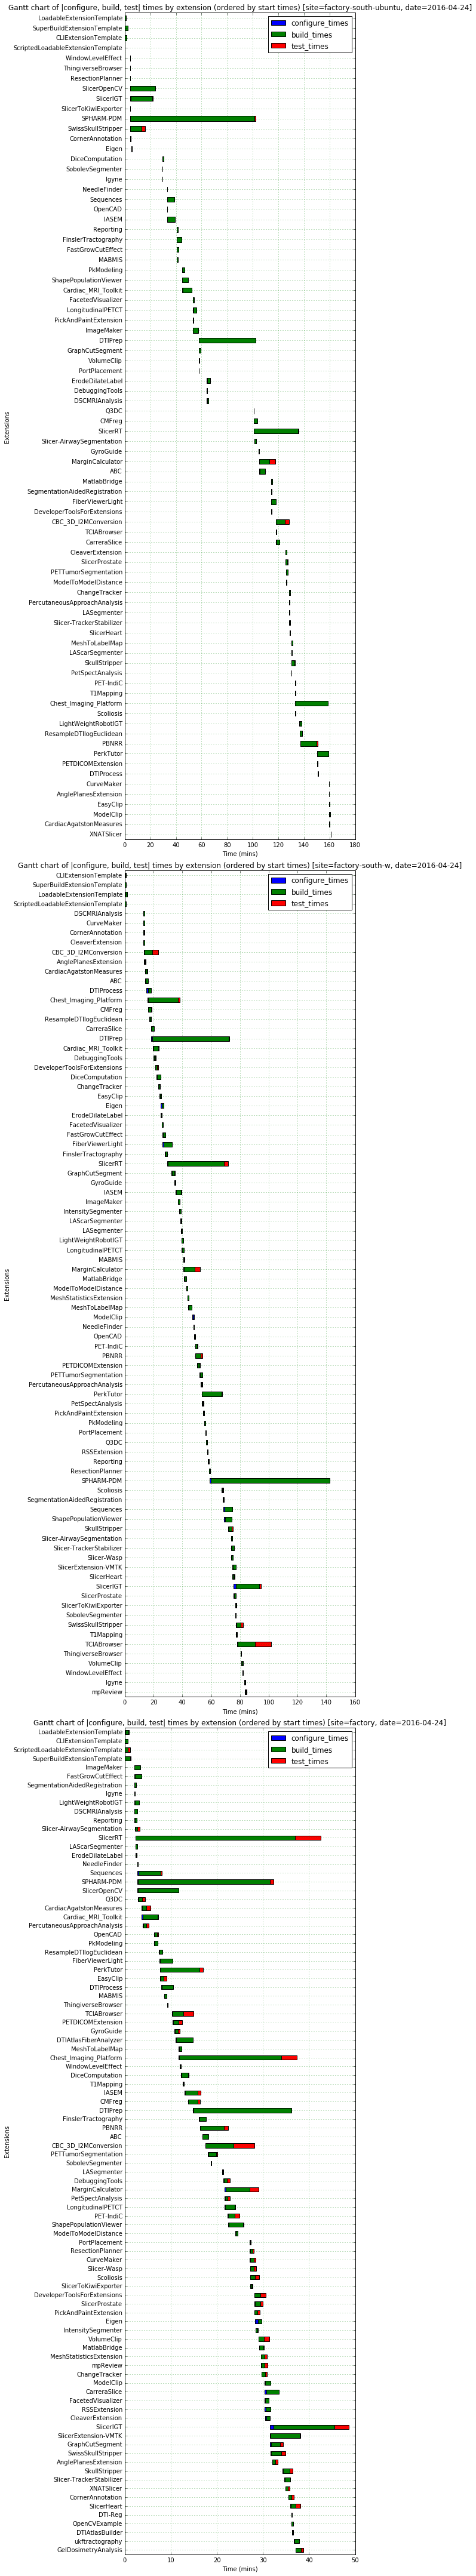

In [7]:

section('plot_2')

figsize = (10, 60)

fig, axes = plt.subplots(len(sites), sharex=False)
axes_index = iter(range(len(axes)))

for site in sites:

    title = "Gantt chart of |configure, build, test| times by extension (ordered by start times) [site=%s, date=%s]" % (site, date)

    # select rows matching 'site'
    sites_sorted_df = sites_df.xs((site), level=('sites')).sort_values(by='start_times', ascending=False)

    time_plot_df = (((sites_sorted_df[timedelta_columns]).
                     apply(lambda td: td / np.timedelta64(1, 'm'))) # convert timedeltas to floats
                   )

    barh_x = sites_sorted_df['start_times']
    barh_x = (barh_x - barh_x.min()) / np.timedelta64(1, 'm')

    ax = time_plot_df.plot.barh(
        ax=axes[next(axes_index)],
        figsize=figsize, 
        title=title,
        use_index=True,
        stacked=True,
        left=barh_x)
    ax.set_xlabel("Time (mins)")
    ax.set_ylabel("Extensions")
    ax.grid(color = 'g', linestyle = ':')

plt.tight_layout();